In [1]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,LSTM,TimeDistributed,Dense,Flatten,Dropout,RepeatVector,GRU,Bidirectional,Permute
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kerastuner as kt
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input
from keras_preprocessing import sequence
from tensorflow.python.keras.layers import Concatenate,concatenate,Activation, dot

import os
adam = Adam(lr=0.001)
filename='pre_data_dl.xlsx'
data_dl=pd.read_excel(filename)
pd.set_option('display.max_columns', None)
print(data_dl.head())

filename1='pre_data_dl_aug1.xlsx'
filename2='pre_data_dl_aug2.xlsx'

data_dl_aug1=pd.read_excel(filename1)
pd.set_option('display.max_columns', None)
print(data_dl_aug1.head())

data_dl_aug2=pd.read_excel(filename2)
print(data_dl_aug2.head())

X = (data_dl["Combined Description Cleaned"])
y= (data_dl['Assignment group'])

#categorical encoding y
y=pd.get_dummies(data_dl['Assignment group'])
  

#parameters
max_features=10000
emb_dim=300
batch_size=128
epochs=25
out_dim=74

   Unnamed: 0  Unnamed: 0.1  \
0           0             0   
1           1             1   
2           2             2   
3           3             3   
4           4             4   

                        Combined Description Cleaned Assignment group  
0  login issue user manager name checked the name...            GRP_0  
1  outlook received from hello team my are not in...            GRP_0  
2    cannot log in to received from   cannot on best            GRP_0  
3                         unable to access tool page            GRP_0  
4                                              error            GRP_0  
   Unnamed: 0                       Combined Description Cleaned  \
0           0  login issue user manager name checked the name...   
1           1  outlook received from hello team my are not in...   
2           2  cannot log in to received from hi i cannot on ...   
3           3                         unable to access tool page   
4           4                            

In [2]:
#function for tokenizer
def dfTokenizer(df):
 tokenizer=Tokenizer(num_words=max_features,char_level=False)
 tokenizer.fit_on_texts(df)
 sequences=tokenizer.texts_to_sequences(df)
 return sequences,tokenizer
#tokenization
X,tokenizer = dfTokenizer(data_dl["Combined Description Cleaned"]) 
vocab_size=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size)

#function for padding
def pad(x, length=None):
 if length is None:
   length=max([len(sentence)  for sentence in x])
 return pad_sequences(x,maxlen=length,padding='post')
 
 #padding 
X=pad_sequences(X,padding='post')


#function for splitting the data
def split(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.3,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl
#split the data
X_train,X_test,y_train,y_test=split(X,y)


#configuring the callback
early_stopping =  EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    min_delta=0.001, 
    mode='max'
)


#function for plotting accuracy,loss
def plot(model,history):
 acc = history.history['accuracy']
 val_acc = history.history['val_accuracy']
 loss = history.history['loss']
 val_loss = history.history['val_loss']
 epochs = range(1, len(acc) + 1)
 plt.plot(epochs, acc, 'bo', label='Training acc')
 plt.plot(epochs, val_acc, 'b', label='Validation acc')
 plt.title( ' Training and validation accuracy')
 plt.legend()
 plt.figure()
 plt.plot(epochs, loss, 'bo', label='Training loss')
 plt.plot(epochs, val_loss, 'b', label='Validation loss')
 plt.title('Training and validation loss')
 plt.legend()
 plt.show()
 return 

vocabulary size is:  3316


In [3]:
inp_len=X.shape[1]
#inputs = Input(shape=(inp_len,))

def TRANSFORMER_model12(output_len,emb_dim,input_length):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len))
 model.add(Bidirectional(LSTM(64, return_sequences=False)))
 model.add(Dropout(0.2))
 model.add(RepeatVector(64))
 model.add(Bidirectional(LSTM(64, return_sequences=True)))
 model.add(TimeDistributed(Dense(units = 64, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
 return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 300)          3000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               186880    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 64, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 64, 64)            8256      
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

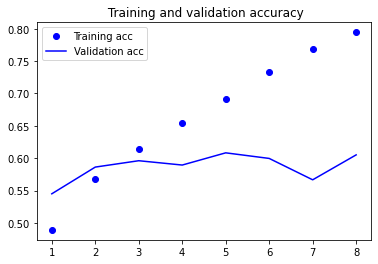

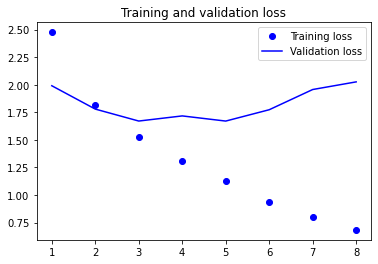

In [4]:
        
modelname="TRANSFORMERModel"
TRANSFORMER_model=TRANSFORMER_model12(max_features,emb_dim,inp_len) 

history=TRANSFORMER_model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs,validation_data=(X_test,y_test),callbacks=[early_stopping])
plot(TRANSFORMER_model,history)

In [5]:

print("Accuracy of TRANSFORMER for unaugmented data is :", np.array(history.history['val_accuracy']).mean()*100)
#print("Validation Accuracy of TRANSFORMER for unagumented data is:", (scores_TRANSFORMER_val[1]*100))
print("Training Accuracy of TRANSFORMER for unagumented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of TRANSFORMER for unaugmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  Training data of TRANSFORMER for unaugmented data is :",np.array(history.history['loss']).mean())        

Accuracy of TRANSFORMER for unaugmented data is : 58.70333909988403
Training Accuracy of TRANSFORMER for unagumented data is: 66.4167795330286
Mean loss of  Validation data of TRANSFORMER for unaugmented data is : 1.8228887915611267
Mean loss of  Training data of TRANSFORMER for unaugmented data is : 1.3349684253335


In [6]:
X_aug1 = (data_dl_aug1["Combined Description Cleaned"])
y_aug1= (data_dl_aug1['Assignment group'])

#categorical encoding y
y_aug1=pd.get_dummies(data_dl_aug2['Assignment group'])


X_aug2 = (data_dl_aug2["Combined Description Cleaned"])
y_aug2= (data_dl_aug2['Assignment group'])

In [7]:
#categorical encoding y
y_aug2=pd.get_dummies(data_dl_aug2['Assignment group'])

#tokenization
X_aug1,tokenizer = dfTokenizer(data_dl_aug1["Combined Description Cleaned"]) 
vocab_size_aug1=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug1)

X_aug2,tokenizer = dfTokenizer(data_dl_aug2["Combined Description Cleaned"]) 
vocab_size_aug2=len(tokenizer.word_index)
print("vocabulary size is: ",vocab_size_aug2)

vocabulary size is:  3956
vocabulary size is:  4424


In [8]:
#padding
X_aug1=pad_sequences(X_aug1,padding='post')
X_aug2=pad_sequences(X_aug2,padding='post')
y_aug1=y_aug1[0:17586]

In [9]:
#split the data.Only augmented data is split using stratify
def split_stratify(X,y):
 X_train_spl,X_test_spl,y_train_spl,y_test_spl=train_test_split(X,y,test_size=0.3,stratify=y,random_state=123)
 return X_train_spl,X_test_spl,y_train_spl,y_test_spl

X_train_aug1,X_test_aug1,y_train_aug1,y_test_aug1=split_stratify(X_aug1,y_aug1)
X_train_aug2,X_test_aug2,y_train_aug2,y_test_aug2=split_stratify(X_aug2,y_aug2)


inp_len1=X_aug1.shape[1]
inp_len2=X_aug2.shape[1]
print(inp_len1)
print(inp_len2)

191
191


In [10]:
def TRANSFORMER_model13(output_len,emb_dim,input_length):
 model = tf.keras.Sequential()
 model.add(Embedding(max_features,emb_dim,input_length=inp_len1))
 model.add(Bidirectional(LSTM(64, return_sequences=False)))
 model.add(Dropout(0.2))
 model.add(RepeatVector(64))
 model.add(Bidirectional(LSTM(64, return_sequences=True)))
 model.add(TimeDistributed(Dense(units = 64, activation = 'relu')))
 model.add(Flatten())
 model.add(Dense(74, activation='softmax'))
 print(model.summary())
 model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
 return model




Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 191, 300)          3000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 64, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64, 128)           98816     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 64)            8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

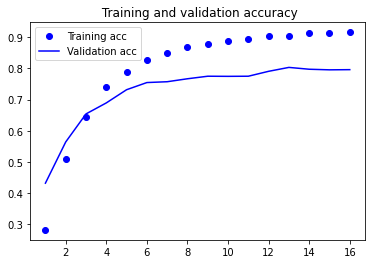

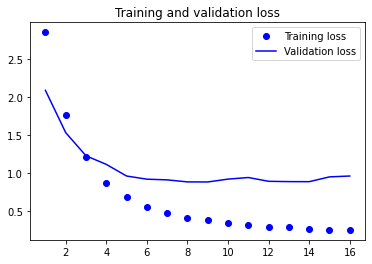

In [11]:
modelname="TRANSFORMERModel_aug1"
TRANSFORMER_model1=TRANSFORMER_model13(max_features,emb_dim,inp_len1)
history=TRANSFORMER_model1.fit(X_train_aug1,y_train_aug1,batch_size=batch_size,epochs=epochs,validation_data=(X_test_aug1,y_test_aug1),callbacks=[early_stopping])
plot(TRANSFORMER_model1,history)

In [12]:
#scores_TRANSFORMER_aug1 =TRANSFORMER_model1.evaluate(X_test_aug1, y_test_aug1, verbose=0)
#scores_TRANSFORMER_val_aug1 = TRANSFORMER_model1.evaluate(X_train_aug1, y_train_aug1, verbose=0)
print("Accuracy of TRANSFORMER for level1 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
#print("Validation Accuracy of TRANSFORMER for level1 augmented data is:", (scores_TRANSFORMER_val_aug1[1]*100))
print("Training Accuracy of TRANSFORMER for level1 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of TRANSFORMER for level1 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of TRANSFORMER for level1 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of TRANSFORMER for level1 augmented data is : 72.85111825913191
Training Accuracy of TRANSFORMER for level1 augmented data is: 79.48720511049032
Mean loss of  Validation data of TRANSFORMER for level1 augmented data is : 1.0602614730596542
Mean loss of  training data of TRANSFORMER for level1 augmented data is : 0.7028384152799845


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 191, 300)          3000000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 64, 128)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64, 128)           98816     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 64, 64)            8256      
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)             

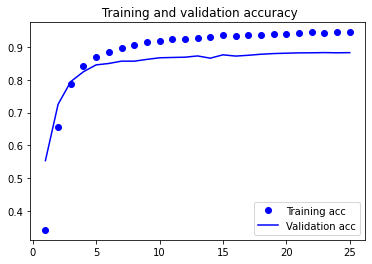

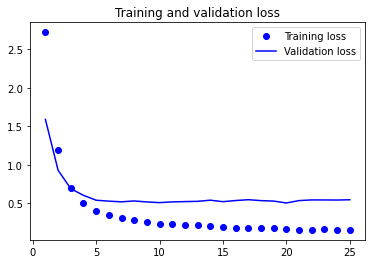

In [13]:
modelname="TRANSFORMERModel_aug2"
TRANSFORMER_model2=TRANSFORMER_model13(max_features,emb_dim,inp_len2)
history=TRANSFORMER_model1.fit(X_train_aug2,y_train_aug2,batch_size=batch_size,epochs=epochs,validation_data=(X_test_aug2,y_test_aug2),callbacks=[early_stopping])
plot(TRANSFORMER_model2,history)

In [14]:
#scores_TRANSFORMER_aug2 =TRANSFORMER_model1.evaluate(X_test_aug2, y_test_aug2, verbose=0)
#scores_TRANSFORMER_val_aug2 = TRANSFORMER_model1.evaluate(X_train_aug2, y_train_aug2, verbose=0)
print("Accuracy of TRANSFORMER for level2 augmented data is :", np.array(history.history['val_accuracy']).mean()*100)
#print("Validation Accuracy of TRANSFORMER for level2 augmented data is:", (scores_TRANSFORMER_val_aug2[1]*100))
print("Training Accuracy of TRANSFORMER for level2 augmented data is:" ,np.array(history.history['accuracy']).mean()*100)
print( "Mean loss of  Validation data of TRANSFORMER for level2 augmented data is :",np.array(history.history['val_loss']).mean())
print( "Mean loss of  training data of TRANSFORMER for level2 augmented data is :",np.array(history.history['loss']).mean())

Accuracy of TRANSFORMER for level2 augmented data is : 84.81434845924377
Training Accuracy of TRANSFORMER for level2 augmented data is: 88.35654807090759
Mean loss of  Validation data of TRANSFORMER for level2 augmented data is : 0.596022572517395
Mean loss of  training data of TRANSFORMER for level2 augmented data is : 0.38554899334907533
